## Importação de Bibliotecas e Dependências

Nesta célula, importamos todas as ferramentas necessárias para construir, treinar e visualizar o modelo de Deep Learning:

* **PyTorch Core (`torch`):** A biblioteca principal para computação tensorial.
* **Módulos de Rede (`torch.nn`):** Contém as camadas (layers), funções de ativação e funções de perda para construir a arquitetura da rede neural.
* **Otimizadores (`torch.optim`):** Fornece algoritmos de otimização (como SGD, Adam) para atualizar os pesos da rede.
* **Torchvision (`torchvision` e `transforms`):** Utilitários específicos para visão computacional, incluindo datasets populares e funções para pré-processamento de imagens.
* **Carregamento de Dados (`DataLoader`):** Facilita a criação de iteradores para carregar os dados em lotes (batches) durante o treinamento.
* **Visualização (`matplotlib` e `numpy`):** Utilizados para plotar gráficos de perda/acurácia e visualizar as imagens do dataset.

In [ ]:
%pip install -q torch torchvision

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder 
import matplotlib.pyplot as plt
import numpy as np

## Definição da Arquitetura: AlexNet Simplificada

Aqui definimos a classe do nosso modelo, herdando de `nn.Module` (a classe base do PyTorch). A arquitetura é dividida em dois blocos sequenciais principais:

1.  **`self.features` (Extrator de Características):**
    * Responsável por "olhar" a imagem e identificar padrões (bordas, texturas, formas).
    * Composto por 5 camadas de **Convolução** (`Conv2d`), intercaladas com funções de ativação **ReLU** (para não-linearidade) e **Max Pooling** (para reduzir a dimensionalidade espacial e focar nas características mais fortes).
    * Note que a profundidade (canais) aumenta (3 -> 64 -> ... -> 256) enquanto o tamanho da imagem diminui.

2.  **`self.classifier` (Classificador):**
    * Responsável por pegar as características extraídas e decidir qual é a classe da imagem.
    * Utiliza camadas **Lineares** (Fully Connected).
    * Inclui **Dropout** (`p=0.5`), uma técnica crucial que "desliga" neurônios aleatoriamente durante o treino para forçar a rede a aprender caminhos robustos e evitar *overfitting*.

3.  **Método `forward`:**
    * Define o fluxo dos dados. O passo crucial aqui é o `torch.flatten`, que "aplainar" o tensor 3D vindo das convoluções em um vetor 1D para que o classificador possa processá-lo.

In [23]:
# Célula de Definição da Arquitetura (Rode esta antes do treino!)

class AlexNetSimplificada(nn.Module):
    def __init__(self, num_classes=3): # <--- Atenção: O padrão aqui pode ser 10, mas o treino vai sobrescrever
        super(AlexNetSimplificada, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Carregamento de Dataset Customizado (Arte)

* **`ImageFolder`:** Esta função mágica do PyTorch varre a pasta raiz indicada, trata cada subpasta como uma **classe** diferente e carrega as imagens automaticamente.
* **Transformações:** Como as pinturas têm tamanhos variados (ao contrário do CIFAR que é 32x32 fixo), aplicamos `Resize((224, 224))` para padronizar a entrada da rede.
* **`random_split`:** Divide automaticamente nosso "bandejão" de imagens em dois grupos:
    * **Treino (80%):** Para a rede aprender os estilos.
    * **Teste (20%):** Para validarmos se ela realmente aprendeu a generalizar.

In [29]:

CAMINHO_DO_DATASET = 'C:\\Users\\igorg\\Documents\\AMS\\dataset'
BATCH_SIZE = 32        # Reduzi um pouco pois imagens de arte costumam ser mais pesadas
LEARNING_RATE = 0.0001
EPOCHS = 7            # Aumentei pois dados reais são mais difíceis de aprender
NUM_CLASSES = 3        # Barroco, Renascentista, Impressionismo (ajuste conforme suas pastas)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformações (Essencial: Resize para 224x224 pois as artes têm tamanhos variados)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("Lendo imagens das pastas...")

# Carrega o dataset inteiro da pasta
dataset_completo = ImageFolder(root=CAMINHO_DO_DATASET, transform=transform)

# Mostra quais classes ele encontrou baseado nos nomes das pastas
print(f"Classes encontradas: {dataset_completo.classes}")

# --- DIVISÃO AUTOMÁTICA TREINO vs TESTE ---
# Vamos usar 80% para treino e 20% para teste
tamanho_treino = int(0.8 * len(dataset_completo))
tamanho_teste = len(dataset_completo) - tamanho_treino

train_dataset, test_dataset = random_split(dataset_completo, [tamanho_treino, tamanho_teste])

print(f"Total de imagens: {len(dataset_completo)}")
print(f"Imagens de Treino: {len(train_dataset)}")
print(f"Imagens de Teste: {len(test_dataset)}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Usando dispositivo: cuda
Lendo imagens das pastas...
Classes encontradas: ['Baroque', 'Expressionism', 'Symbolism']
Total de imagens: 3600
Imagens de Treino: 2880
Imagens de Teste: 720


## Treinamento (Transfer Learning / Custom)

Adaptação do loop de treinamento para o contexto de Classificação de Estilos Artísticos.

* **Ajuste de Classes:** O modelo é instanciado com `num_classes=3` (ou 4, dependendo de quantas pastas você usar).
* **Processamento:** Dado o tamanho das imagens e a complexidade dos estilos artísticos, o treinamento pode levar mais tempo.
* **Monitoramento:** Acompanhamos a perda (`Loss`) a cada batch para garantir que a rede está convergindo (diminuindo o erro) ao diferenciar um Picasso de um Rembrandt.

In [30]:
# Lista para guardar o erro (loss) de cada batch para plotar depois
historico_loss = []

model = AlexNetSimplificada(num_classes=NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Iniciando treinamento para {NUM_CLASSES} estilos de arte...")

for epoch in range(EPOCHS):
    model.train() 
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # --- AQUI ESTÁ A MUDANÇA ---
        # Salvamos o valor do erro na lista para usar no gráfico
        historico_loss.append(loss.item()) 
        # ---------------------------

        running_loss += loss.item()
        
        # Altere O NUMERO AQUI (Ex: de 5 para 50)
        INTERVALO_PRINT = 50 
        
        if (i+1) % INTERVALO_PRINT == 0: 
            # Lembre de dividir pelo mesmo número aqui embaixo também!
            print(f"Época [{epoch+1}/{EPOCHS}], Passo [{i+1}/{len(train_loader)}], Perda: {running_loss/INTERVALO_PRINT:.4f}")
            running_loss = 0.0

print("Treinamento de Arte concluído!")

Iniciando treinamento para 3 estilos de arte...
Época [1/7], Passo [50/90], Perda: 1.0456
Época [2/7], Passo [50/90], Perda: 0.9612
Época [3/7], Passo [50/90], Perda: 0.9251
Época [4/7], Passo [50/90], Perda: 0.8676
Época [5/7], Passo [50/90], Perda: 0.8400
Época [6/7], Passo [50/90], Perda: 0.7906
Época [7/7], Passo [50/90], Perda: 0.7491
Treinamento de Arte concluído!


## Teste Visual de Estilos Artísticos

Exibe as predições do modelo em imagens inéditas (do conjunto de teste).

* **Rótulos Dinâmicos:** O código puxa os nomes das classes (`dataset_completo.classes`) diretamente dos nomes das pastas que você criou.
* **Desnormalização:** Ajusta as cores para exibir a pintura original corretamente.
* **Verificação:** Permite analisar visualmente se o modelo capturou a essência de cada movimento artístico (ex: se confundiu o dramatismo do Barroco com o Simbolismo).

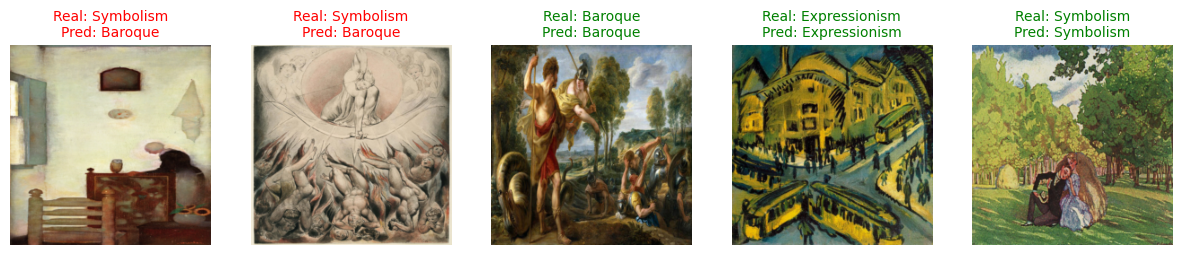

In [31]:
def mostrar_predicoes_arte():
    # Pega os nomes das classes direto do dataset original
    classes = dataset_completo.classes
    
    # Pega um batch do loader de TESTE
    images, labels = next(iter(test_loader))
    
    # Limita a 5 imagens para mostrar
    images = images[:5]
    labels = labels[:5]
    
    images_device = images.to(device)
    model.eval()
    outputs = model(images_device)
    _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(15, 5))
    
    for i in range(len(images)):
        ax = fig.add_subplot(1, 5, i+1)
        
        # Desnormalizar
        img = images[i] / 2 + 0.5
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
        cor = 'green' if predicted[i] == labels[i] else 'red'
        
        # Mostra o nome do estilo artístico
        titulo = f"Real: {classes[labels[i]]}\nPred: {classes[predicted[i]]}"
        ax.set_title(titulo, color=cor, fontsize=10)
        ax.axis('off')
    
    plt.show()

mostrar_predicoes_arte()

## Análise de Convergência (Curva de Aprendizado)

Plota a evolução do erro (Loss) ao longo das iterações.
* **Objetivo:** Visualizar se a rede está aprendendo.
* **Interpretação:** Uma curva descendente suave indica um bom aprendizado. Oscilações fortes ou uma linha reta indicam problemas com a Taxa de Aprendizado (Learning Rate).

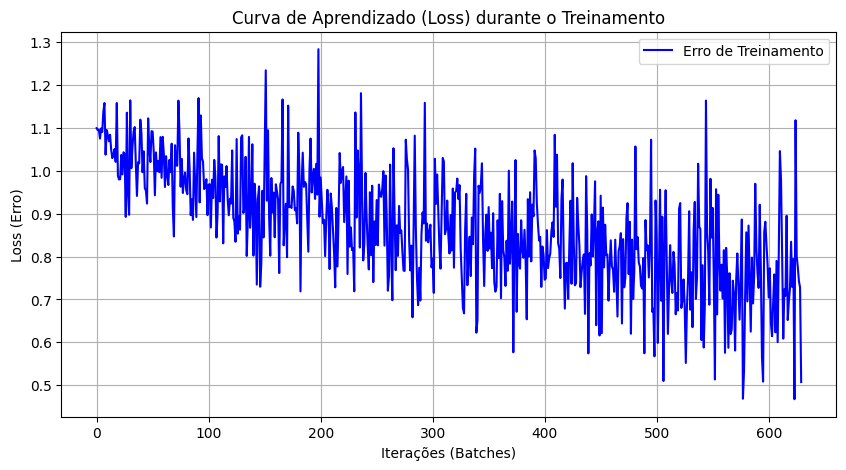

In [32]:
def plotar_curva_aprendizado():
    plt.figure(figsize=(10, 5))
    plt.plot(historico_loss, label='Erro de Treinamento', color='blue')
    plt.title('Curva de Aprendizado (Loss) durante o Treinamento')
    plt.xlabel('Iterações (Batches)')
    plt.ylabel('Loss (Erro)')
    plt.legend()
    plt.grid(True)
    plt.show()

plotar_curva_aprendizado()

## Validação Quantitativa (Acurácia Global)

Mede a performance exata do modelo em todo o conjunto de teste (imagens nunca vistas).
* **Processo:** Percorre o `test_loader`, faz predições e compara com os rótulos reais.
* **Resultado:** Retorna a porcentagem total de acertos (ex: 85%).

In [33]:
def calcular_acuracia_total():
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f'Acurácia final no conjunto de teste: {acc:.2f}%')

calcular_acuracia_total()

Acurácia final no conjunto de teste: 69.72%


## Persistência do Modelo

Salva os pesos treinados da rede neural em um arquivo físico (`.pth`).
Isso permite reutilizar o modelo treinado futuramente sem precisar rodar as horas de treinamento novamente.

In [34]:
import os

# Salva na mesma pasta do dataset
nome_arquivo = 'classificador_arte_alexnet.pth'
caminho_final = os.path.join(CAMINHO_DO_DATASET, nome_arquivo)

torch.save(model.state_dict(), caminho_final)

print(f"Modelo salvo com sucesso em: {caminho_final}")

Modelo salvo com sucesso em: C:\Users\igorg\Documents\AMS\dataset\classificador_arte_alexnet.pth


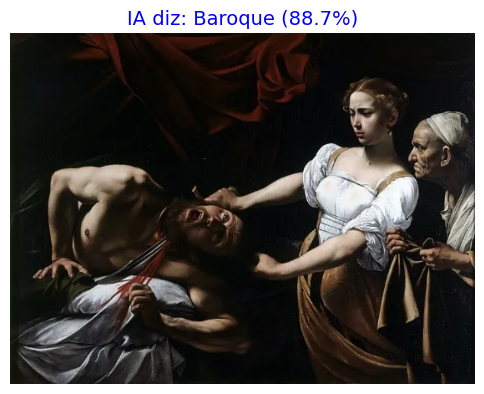


--- O que a IA pensou ---
Baroque: 88.70%
Expressionism: 5.29%
Symbolism: 6.01%


In [35]:
from PIL import Image

# 1. Configure aqui o caminho da imagem que você baixou da internet
CAMINHO_DA_IMAGEM = 'C:\\Users\\igorg\\Documents\\AMS\\Images\\barroco.webp'  

# 2. Prepara a imagem (Usa o mesmo 'transform' que já definimos lá em cima)
image = Image.open(CAMINHO_DA_IMAGEM).convert('RGB')
input_tensor = transform(image).unsqueeze(0) # Adiciona a dimensão do lote (1, 3, 224, 224)
input_tensor = input_tensor.to(device)

# 3. Faz a previsão usando o modelo que já está na memória
model.eval() # Garante que está em modo de teste
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top_prob, top_catid = torch.topk(probabilities, 1)

# 4. Pega os nomes das classes que o dataset já descobriu
classes_nomes = dataset_completo.classes

# 5. Mostra o resultado
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
texto = f"IA diz: {classes_nomes[top_catid.item()]} ({top_prob.item()*100:.1f}%)"
plt.title(texto, color='blue', fontsize=14)
plt.show()

# Mostra as porcentagens de cada estilo
print("\n--- O que a IA pensou ---")
for i, prob in enumerate(probabilities):
    print(f"{classes_nomes[i]}: {prob.item()*100:.2f}%")

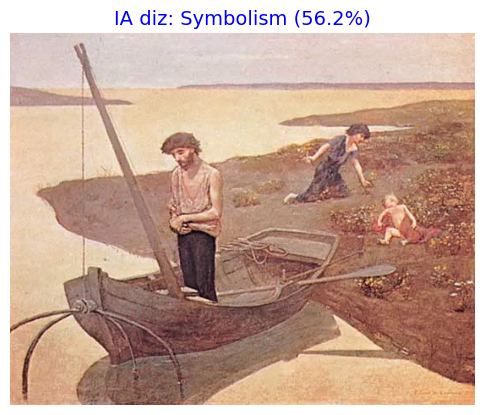


--- O que a IA pensou ---
Baroque: 27.24%
Expressionism: 16.52%
Symbolism: 56.23%


In [36]:
from PIL import Image

# 1. Configure aqui o caminho da imagem que você baixou da internet
CAMINHO_DA_IMAGEM = 'C:\\Users\\igorg\\Documents\\AMS\\Images\\symbolism.webp'  

# 2. Prepara a imagem (Usa o mesmo 'transform' que já definimos lá em cima)
image = Image.open(CAMINHO_DA_IMAGEM).convert('RGB')
input_tensor = transform(image).unsqueeze(0) # Adiciona a dimensão do lote (1, 3, 224, 224)
input_tensor = input_tensor.to(device)

# 3. Faz a previsão usando o modelo que já está na memória
model.eval() # Garante que está em modo de teste
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top_prob, top_catid = torch.topk(probabilities, 1)

# 4. Pega os nomes das classes que o dataset já descobriu
classes_nomes = dataset_completo.classes

# 5. Mostra o resultado
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
texto = f"IA diz: {classes_nomes[top_catid.item()]} ({top_prob.item()*100:.1f}%)"
plt.title(texto, color='blue', fontsize=14)
plt.show()

# Mostra as porcentagens de cada estilo
print("\n--- O que a IA pensou ---")
for i, prob in enumerate(probabilities):
    print(f"{classes_nomes[i]}: {prob.item()*100:.2f}%")